# Introdução

O presente relatório, através da análise de Big Data, visa identificar as vias da cidade com buracos, estimar os custos de reparo/manutenção e identificar os segmentos que provocam maior impacto negativo no bem-estar dos cidadãos.

# Parametrização das Variáveis

## Definindo os Parâmetros

In [2]:
%env PROJ_LIB=/home/master/anaconda3/envs/ox_gpd/share/proj

env: PROJ_LIB=/home/master/anaconda3/envs/ox_gpd/share/proj


In [3]:
from datetime import datetime as dt
from datetime import timedelta as td

cost_per_meter = 23.4
lane_size = 2.8

# city = 'Miraflores'
# table = 'pe_lima_waze_alerts'
# start_date = dt(2019,6,15)
# end_date = dt(2019,6,30)

# osm_place = "Distrito de Miraflores"

city = 'São Paulo'
table = 'br_saopaulo_waze_alerts'
start_date = dt(2019,6,10)
end_date = dt(2019,7,15)
osm_place = {'city' : 'São Paulo',
             'state' : 'São Paulo',
             'country' : 'Brasil'}
which_result=1

## Imports and Configuration

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import logging
import warnings
import datetime
import pytz
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import matplotlib.pyplot as plt

from matplotlib import colors, cm
from pathlib import Path 
from shapely.geometry import Point
from IPython.display import display, Markdown
from scipy.stats import pareto
from scipy.spatial import cKDTree

# Setting matplotlib font size
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)

current_path = Path().resolve()
abs_path = str(current_path.parent)
sys.path.append(abs_path)

RAW_PATH = current_path.parent / 'data' / 'raw'
OUTPUT_PATH = current_path.parent / 'data' / 'output' / city

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


In [5]:
import scripts.pot_holes_cost as phc
from scripts.mod_simplify import simplify_graph

In [6]:
from h3 import h3
import folium
import json
from geojson.feature import *

import branca.colormap as bcm
from branca.colormap import linear

from IPython.display import display, HTML, Image
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster

from pandas.io.json import json_normalize

In [8]:
date_string_parser='%d/%m/%y'
print(f"""Os parâmetros definidos para elaboração deste relatório são os seguintes:

Vias:

Custo médio por metro quadro de reparo das vias: {cost_per_meter:.2f}U$/m^2
Largura média das vias: {lane_size:.2f}m

Período:
Data de ínicio dos alertas: {start_date.strftime(date_string_parser)}
Data final dos alertas: {end_date.strftime(date_string_parser)}""")

Os parâmetros definidos para elaboração deste relatório são os seguintes:

Vias:

Custo médio por metro quadro de reparo das vias: 23.40U$/m^2
Largura média das vias: 2.80m

Período:
Data de ínicio dos alertas: 10/06/19
Data final dos alertas: 15/07/19


# Obtendo os Dados

## Buracos

Os dados relativo aos buracos foram extraídos de nosso servidor de Big Data que armazena as informações do Waze. Os alertas de buracos são criados pelos próprios usuários do aplicativo para alertar as demais pessoas sobre as condições da via.

In [399]:
pot_holes = phc.download_potholes_data(template_fp='../templates/pot_holes.sql', city=city, table=table, 
                                       start_date=start_date, end_date=end_date, workgroup='Test')

In [10]:
display(Markdown(
    f"A tabela abaixo mostra os cinco buracos com a maior quantidade de reclamações da cidade no período entre {start_date.strftime('%d/%m/%y')} - {end_date.strftime('%d/%m/%y')}"))

A tabela abaixo mostra os cinco buracos com a maior quantidade de reclamações da cidade no período entre 10/06/19 - 15/07/19

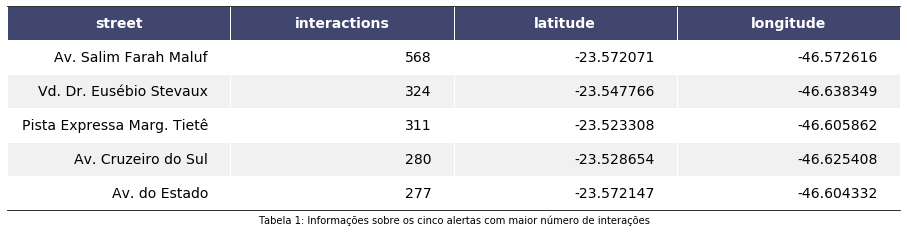

In [11]:
top5 = pot_holes[['street', 'interactions', 'latitude', 'longitude', ]].sort_values('interactions', ascending=False).head()
top5['latitude'] = top5['latitude'].apply(lambda x: f"{x:,.6f}")
top5['longitude'] = top5['longitude'].apply(lambda x: f"{x:,.6f}")
fig, ax, table = phc.render_mpl_table(top5, 'potholes_top5.png', city)#col_width=7
ax.set_xlabel(f"Tabela 1: Informações sobre os cinco alertas com maior número de interações");

In [12]:
display(Markdown(f"""Total de alertas: {pot_holes.shape[0]}

Total de interações: {pot_holes.interactions.sum()}"""))

Total de alertas: 37807

Total de interações: 438020

## Open Street Maps (OSM)

Para complementar nosso estudo, baixamos as informações das vias da cidade disponibilizadas no Open Street Maps, um projeto de mapeamento colaborativo para criar um mapa livre e editável do mundo. Com uma rede de mais de 2 milhões de colaboradores ao redor do mundo, o OSM oferece mapas detalhados de diversas localidades, sendo uma excelente fonte de informação sobre a estrutura viária dos municípios.

In [7]:
if osm_place:
    G = phc.download_osm_graph(city, osm_place, simplify=False, which_result=which_result)
else:
    lats = pot_holes['latitude'].values
    longs = pot_holes['longitude'].values
    north, south, east, west = max(lats), min(lats), max(longs), min(longs)
    G = phc.download_osm_graph(city, north=north, south=south, east=east, west=west, simplify=False, cached=False, cache_result=False)

In [8]:
G_proj = ox.project_graph(G) 

A imagem abaixo mostra todas as vias públicas da cidade registradas no OSM.

In [17]:
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=12, show=False, axis_off=False, edge_linewidth=0.2)
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel(f"Figura 1: Vias públicas da cidade de {city} obtidas através do Open Street Maps");

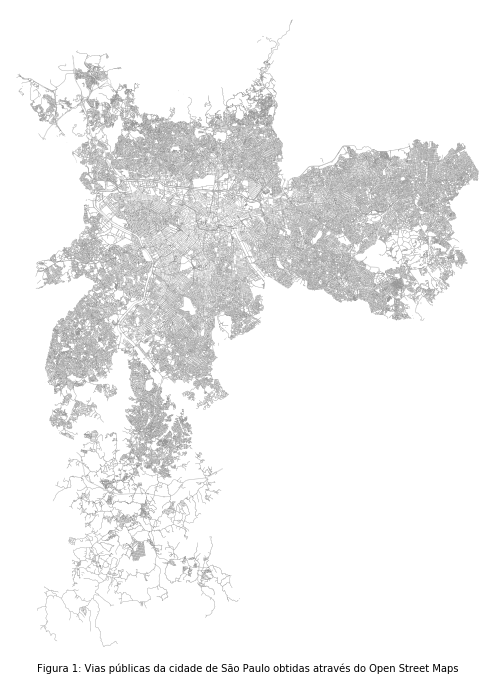

In [18]:
fig

# Treat Data <a class='tocSkip'>

## Potholes to shapely <a class='tocSkip'>

In [400]:
pot_holes.head()

,uuid,latitude,longitude,interactions,street,reliability,start_time,end_time,share,cum_share
0,3f2d60a2-825b-38f8-b3de-2b9ed0609d29,-23.572071,-46.572616,568,Av. Salim Farah Maluf,10,2019-06-20 19:20:00.000,2019-07-02 19:57:00.000,0.0013,0.001297
1,6f452af1-7aef-3404-961b-50154eee3c4d,-23.547766,-46.638349,324,Vd. Dr. Eusébio Stevaux,10,2019-06-09 23:57:00.000,2019-06-16 01:48:00.000,0.0007,0.002036
2,11b90cb3-467a-3ae3-89e1-d93edcace33d,-23.523308,-46.605862,311,Pista Expressa Marg. Tietê,10,2019-06-13 21:25:00.000,2019-06-23 16:08:00.000,0.0007,0.002746
3,ce93d236-6ce3-3174-a903-1217555e989a,-23.528654,-46.625408,280,Av. Cruzeiro do Sul,10,2019-06-25 12:10:00.000,2019-07-06 18:44:00.000,0.0006,0.003386
4,bce3240f-1f05-38b9-8abd-64d11b7e7828,-23.572147,-46.604332,277,Av. do Estado,10,2019-06-09 23:57:00.000,2019-06-17 18:31:00.000,0.0006,0.004018


In [401]:
pot_holes = phc.treat_potholes_points(pot_holes)

## Usando h3

### Visualizando os Hexágonos

In [9]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [10]:
lat_centr_point = -23.5489 
lon_centr_point = -46.6388
max_res = 10
list_hex_res = []
list_hex_res_geom = []
list_res = range(7,max_res+1)

for resolution in list_res:
    #index the point in the H3 hexagon of given index resolution
    h = h3.geo_to_h3(lat=lat_centr_point,lng=lon_centr_point, res=resolution)
    list_hex_res.append(h)
    #get the geometry of the hexagon and convert to geojson
    h_geom = { "type" : "Polygon",
               "coordinates": 
                    [h3.h3_to_geo_boundary(h3_address=h,geo_json=True)]
              }
    list_hex_res_geom.append(h_geom)

    
df_resolution_example = pd.DataFrame({"res" : list_res,
                                      "hex_id" : list_hex_res,
                                      "geometry": list_hex_res_geom 
                                     })
df_resolution_example["hex_id_binary"] = df_resolution_example["hex_id"].apply(lambda x: bin(int(x,16))[2:])

In [31]:
map_example = Map(location= [-23.5489, -46.6388], zoom_start=14, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )

list_features = []
for i,row in df_resolution_example.iterrows():
    feature = Feature(geometry = row["geometry"], id=row["hex_id"], properties = {"resolution": int(row["res"])})
    list_features.append(feature)

feat_collection = FeatureCollection(list_features)
geojson_result = json.dumps(feat_collection)


GeoJson(
        geojson_result,
        style_function=lambda feature: {
            'fillColor': None,
            'color': "green" if feature['properties']['resolution'] %2 == 0 else "red",
            'weight': 2,
            'fillOpacity': 0
        }, 
        name = "Example" 
    ).add_to(map_example)

map_example

In [41]:
h3_address = h3.geo_to_h3(-23.5489, -46.6388, 7) # lat, lng, hex resolution                                                                                                
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]                                                                                                                  
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]                                                                                                                                                                                                                                                         
#m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[3]), color="purple")
#m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[1]), color="green")#, folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[0]), color = "red", folium_map=m)
display(m)

In [40]:
h3_address = h3.geo_to_h3(-23.5489, -46.6388, 8) # lat, lng, hex resolution                                                                                                
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]                                                                                                                  
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]                                                                                                                                                                                                                                                         
#m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[3]), color="purple")
#m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[1]), color="green")#, folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[0]), color = "red", folium_map=m)
display(m)

### Indexando os dados espacialmente com h3

In [11]:
def counts_by_hexagon(df, resolution):
    
    '''Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
      Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons'''

    df = df[["latitude","longitude"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: 
                                                           {    "type" : "Polygon",
                                                                 "coordinates": 
                                                                [h3.h3_to_geo_boundary(h3_address=x,geo_json=True)]
                                                            }
                                                        )
    
    return df_aggreg

In [12]:
def hexagons_dataframe_to_geojson(df_hex, file_output = None):
    
    '''Produce the GeoJSON for a dataframe that has a geometry column in geojson format already, along with the columns hex_id and value '''
    
    list_features = []
    
    for i,row in df_hex.iterrows():
        feature = Feature(geometry = row["geometry"] , id=row["hex_id"], properties = {"value" : row["value"]})
        list_features.append(feature)
        
    feat_collection = FeatureCollection(list_features)
    
    geojson_result = json.dumps(feat_collection)
    
    #optionally write to file
    if file_output is not None:
        with open(file_output,"w") as f:
            json.dump(feat_collection,f)
    
    return geojson_result

def choropleth_map(df_aggreg, border_color = 'black', fill_opacity = 0.7, initial_map = None, with_legend = False,
                   kind = "linear"):
    #colormap
    min_value = df_aggreg["value"].min()
    max_value = df_aggreg["value"].max()
    m = round ((min_value + max_value ) / 2 , 0)
    
    #take resolution from the first row
    res = h3.h3_get_resolution(df_aggreg.loc[0,'hex_id'])
    
    if initial_map is None:
        initial_map = Map(location= [43.600378, 1.445478], zoom_start=11, tiles="cartodbpositron", 
                attr= '© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="http://cartodb.com/attributions#basemaps">CartoDB</a>' 
            )
        

    #the colormap 
    #color names accepted https://github.com/python-visualization/branca/blob/master/branca/_cnames.json
    if kind == "linear":
        custom_cm = cm.LinearColormap(['green','yellow','red'], vmin=min_value, vmax=max_value)
    elif kind == "outlier":
        #for outliers, values would be -11,0,1
        custom_cm = cm.LinearColormap(['blue','white','red'], vmin=min_value, vmax=max_value)
    elif kind == "filled_nulls":
        custom_cm = cm.LinearColormap(['sienna','green','yellow','red'], 
                                      index=[0,min_value,m,max_value],vmin=min_value,vmax=max_value)
   

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg)
    
    #plot on map
    name_layer = "Choropleth " + str(res)
    if kind != "linear":
        name_layer = name_layer + kind
        
    GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    #add legend (not recommended if multiple layers)
    if with_legend == True:
        custom_cm.add_to(initial_map)
    
    
    
    return initial_map


In [13]:
# transform graph into DataFrame
edges = ox.graph_to_gdfs(G_proj, nodes=False, fill_edge_geometry=True)

In [525]:
edges_before_match = edges

In [14]:
edges.shape

(914411, 19)

In [166]:
edges_test = edges.loc[:1000,['u','v','geometry']]

In [120]:
edges_test['points'] = edges_test.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)
#edges_test = edges_test.drop(columns='geometry')

In [121]:
extended = edges_test['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges_test).reset_index().drop(columns='points')

In [165]:
edges_test.head()

,index,u,v,points
0,0,573640,4361883898,"[POINT (325750.2089603181 -2606496.147666725),..."
1,1,573641,4345300990,"[POINT (326091.699952733 -2606878.923685934), ..."
2,2,573641,465879071,"[POINT (326091.699952733 -2606878.923685934), ..."
3,3,573643,3511818100,"[POINT (326273.1678960377 -2607372.248346813),..."
4,4,573644,5908800467,"[POINT (326586.0654850269 -2607977.440811284),..."


In [94]:
%load_ext memory_profiler

In [455]:
def apply_redistribute_vertices(proj_edges, dist=10):
    edges = proj_edges.copy()
    edges = edges.loc[:,['u','v','geometry']]
    edges['points'] = edges.apply(lambda x: ox.redistribute_vertices(x.geometry, dist), axis=1)
    edges = edges['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges).reset_index()\
            .drop(columns=['points', 'geometry']).rename(columns={'Series': 'points'})
    edges['lon'] = edges['points'].apply(lambda row: row.x) # proj_lon
    edges['lat'] = edges['points'].apply(lambda row: row.y) # proj_lat
    return edges

In [180]:
redistribute_vertices(edges_test.loc[1, 'geometry'], 10)

[[(326091.699952733, -2606878.9236859344)],
 [(326099.75194441125, -2606870.9051309056)],
 [(326107.80393608945, -2606862.8865758767)],
 [(326115.8559277677, -2606854.868020848)]]

In [210]:
edges_test2 = edges.loc[:,['u','v','geometry']].sample(1000)

In [195]:
%timeit edges_test2.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)

321 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [206]:
%memit edges_test2.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)

peak memory: 6037.36 MiB, increment: 0.00 MiB


In [110]:
edges_test2['points'] = edges_test2.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)

In [111]:
%timeit edges_test2['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges_test2).reset_index()

5.43 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
%prun -l 10 edges_test2['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges_test2).reset_index()

In [112]:
%memit edges_test2['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges_test2).reset_index()

peak memory: 6038.32 MiB, increment: 0.01 MiB


In [148]:
edges_test3 = edges.loc[:,['u','v','geometry']].sample(10000)
edges_test3.reset_index(level=0, inplace=True)
edges_test3['points'] = edges_test3.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)

In [244]:
def split_data_frame_list(df, target_column):
    ''' 
    Accepts a column with multiple types and splits list variables to several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]        
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    return row_accumulator

In [149]:
%timeit split_data_frame_list(edges_test3, 'points')

3.16 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [243]:
%timeit pd.DataFrame(split_data_frame_list(edges_test3, 'points'))

3.47 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [270]:
from math import ceil

In [438]:
batch_size = 10000
batches = ceil(edges.shape[0] / batch_size)

In [275]:
edges.shape[0]

914411

In [446]:
batches

92

In [447]:
[(i*batch_size,(i+1)*batch_size) for i in range(batches)][::10]

[(0, 10000),
 (100000, 110000),
 (200000, 210000),
 (300000, 310000),
 (400000, 410000),
 (500000, 510000),
 (600000, 610000),
 (700000, 710000),
 (800000, 810000),
 (900000, 910000)]

In [457]:
extended = pd.DataFrame()
for i in range(batches):
    extended = extended.append(apply_redistribute_vertices(edges.iloc[i*batch_size:(i+1)*batch_size, :]), ignore_index=True)

In [458]:
with open(str(OUTPUT_PATH/'extended_edges.p'), 'wb') as f:
    pickle.dump(extended, f)

In [459]:
extended.drop(columns='points').to_csv(OUTPUT_PATH / "extended_edges.csv")

In [460]:
extended.shape

(3958599, 6)

In [461]:
extended_complete = extended

In [462]:
extended.head()

,index,points,u,v,lon,lat
0,0,POINT (325750.2089603181 -2606496.147666725),573640,4361883898,325750.208960,-2.606496e+06
1,0,POINT (325742.7558397555 -2606491.019806632),573640,4361883898,325742.755840,-2.606491e+06
2,1,POINT (326091.699952733 -2606878.923685934),573641,4345300990,326091.699953,-2.606879e+06
3,1,POINT (326099.7519444113 -2606870.905130906),573641,4345300990,326099.751944,-2.606871e+06
4,1,POINT (326107.8039360894 -2606862.886575877),573641,4345300990,326107.803936,-2.606863e+06


In [463]:
extended.tail()

,index,points,u,v,lon,lat
3958594,914409,POINT (333107.2337742593 -2606127.731349598),6695735702,60641425,333107.233774,-2.606128e+06
3958595,914409,POINT (333106.7350638401 -2606118.472561065),6695735702,60641425,333106.735064,-2.606118e+06
3958596,914409,POINT (333106.2363534207 -2606109.213772532),6695735702,60641425,333106.236353,-2.606109e+06
3958597,914410,POINT (333109.344900528 -2606163.325390026),6695735703,60641427,333109.344901,-2.606163e+06
3958598,914410,POINT (333108.6586608728 -2606154.185031283),6695735703,60641427,333108.658661,-2.606154e+06


In [468]:
extended = extended.rename(columns={'points':'proj_points','lat':'proj_lat','lon':'proj_lon'})

In [469]:
extended.head(1)

,index,proj_points,u,v,proj_lon,proj_lat
0,0,POINT (325750.2089603181 -2606496.147666725),573640,4361883898,325750.20896,-2.606496e+06


In [470]:
extended = extended.set_geometry('proj_points')

In [471]:
extended.head()

,index,proj_points,u,v,proj_lon,proj_lat
0,0,POINT (325750.2089603181 -2606496.147666725),573640,4361883898,325750.208960,-2.606496e+06
1,0,POINT (325742.7558397555 -2606491.019806632),573640,4361883898,325742.755840,-2.606491e+06
2,1,POINT (326091.699952733 -2606878.923685934),573641,4345300990,326091.699953,-2.606879e+06
3,1,POINT (326099.7519444113 -2606870.905130906),573641,4345300990,326099.751944,-2.606871e+06
4,1,POINT (326107.8039360894 -2606862.886575877),573641,4345300990,326107.803936,-2.606863e+06


In [472]:
extended.crs = G_proj.graph['crs']

In [473]:
extended['points'] = extended['proj_points'].to_crs(G.graph['crs'])

In [474]:
extended['lon'] = extended.apply(lambda row: row["points"].x, axis=1)
extended['lat'] = extended.apply(lambda row: row["points"].y, axis=1)

In [475]:
extended.head()

,index,proj_points,u,v,proj_lon,proj_lat,points,lon,lat
0,0,POINT (325750.2089603181 -2606496.147666725),573640,4361883898,325750.208960,-2.606496e+06,POINT (-46.7072495 -23.5594985),-46.707250,-23.559498
1,0,POINT (325742.7558397555 -2606491.019806632),573640,4361883898,325742.755840,-2.606491e+06,POINT (-46.7073219 -23.55945139999999),-46.707322,-23.559451
2,1,POINT (326091.699952733 -2606878.923685934),573641,4345300990,326091.699953,-2.606879e+06,POINT (-46.7039494 -23.5629912),-46.703949,-23.562991
3,1,POINT (326099.7519444113 -2606870.905130906),573641,4345300990,326099.751944,-2.606871e+06,POINT (-46.70386959991367 -23.56291966671329),-46.703870,-23.562920
4,1,POINT (326107.8039360894 -2606862.886575877),573641,4345300990,326107.803936,-2.606863e+06,POINT (-46.70378979991368 -23.56284813337996),-46.703790,-23.562848


In [477]:
extended["hex_id"] = extended.apply(lambda row: h3.geo_to_h3(row["lat"], row["lon"], 8), axis = 1)

In [480]:
with open(str(OUTPUT_PATH/'extended_edges2.p'), 'wb') as f:
    pickle.dump(extended, f)

In [479]:
extended.head(2)

,index,proj_points,u,v,proj_lon,proj_lat,points,lon,lat,hex_id
0,0,POINT (325750.2089603181 -2606496.147666725),573640,4361883898,325750.20896,-2.606496e+06,POINT (-46.7072495 -23.5594985),-46.707250,-23.559498,88a8100e9dfffff
1,0,POINT (325742.7558397555 -2606491.019806632),573640,4361883898,325742.75584,-2.606491e+06,POINT (-46.7073219 -23.55945139999999),-46.707322,-23.559451,88a8100e9dfffff


In [482]:
group_hex = extended[['hex_id', 'points']].groupby("hex_id").count()

In [486]:
group_hex.mean()

points    2102.283059
dtype: float64

In [478]:
h3_hex = pd.DataFrame(extended["hex_id"].unique(), columns=['hex_id']).set_index('hex_id', drop=False)
len(h3_hex)

1883

In [487]:
h3_hex["hex_ring1"] = h3_hex["hex_id"].apply(h3.k_ring, 1, args=(1,))

In [488]:
h3_hex.head()

,hex_id,hex_ring1
hex_id,,
88a8100e9dfffff,88a8100e9dfffff,"{88a8100e99fffff, 88a8100e8bfffff, 88a8100e83f..."
88a8100e83fffff,88a8100e83fffff,"{88a8100e8bfffff, 88a8100e87fffff, 88a8100e81f..."
88a8100e8bfffff,88a8100e8bfffff,"{88a8100e8bfffff, 88a8100e89fffff, 88a8100e83f..."
88a8100e89fffff,88a8100e89fffff,"{88a8100e8bfffff, 88a8100e89fffff, 88a8100e81f..."
88a8100ec1fffff,88a8100ec1fffff,"{88a8100ecdfffff, 88a8100ec9fffff, 88a8100ec5f..."


In [393]:
def construct_KDTree(hex_ring, extended):
    points = extended.loc[extended.hex_id.isin(hex_ring)]['proj_points']
    nbdata = np.array(list(zip(points.apply(lambda point: point.x),
                               points.apply(lambda point: point.y))))
    return cKDTree(data=nbdata, compact_nodes=True, balanced_tree=True)

In [489]:
h3_hex['KDTree'] = h3_hex['hex_ring1'].apply(construct_KDTree,args=(extended,))

In [490]:
h3_hex.head()

,hex_id,hex_ring1,KDTree
hex_id,,,
88a8100e9dfffff,88a8100e9dfffff,"{88a8100e99fffff, 88a8100e8bfffff, 88a8100e83f...",<scipy.spatial.ckdtree.cKDTree object at 0x7f8...
88a8100e83fffff,88a8100e83fffff,"{88a8100e8bfffff, 88a8100e87fffff, 88a8100e81f...",<scipy.spatial.ckdtree.cKDTree object at 0x7f8...
88a8100e8bfffff,88a8100e8bfffff,"{88a8100e8bfffff, 88a8100e89fffff, 88a8100e83f...",<scipy.spatial.ckdtree.cKDTree object at 0x7f8...
88a8100e89fffff,88a8100e89fffff,"{88a8100e8bfffff, 88a8100e89fffff, 88a8100e81f...",<scipy.spatial.ckdtree.cKDTree object at 0x7f8...
88a8100ec1fffff,88a8100ec1fffff,"{88a8100ecdfffff, 88a8100ec9fffff, 88a8100ec5f...",<scipy.spatial.ckdtree.cKDTree object at 0x7f8...


In [491]:
with open(str(OUTPUT_PATH/'h3_hex_KDTree.p'), 'wb') as f:
    pickle.dump(h3_hex, f)

In [405]:
pot_holes['hex_id'] = pot_holes.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 8), axis = 1)

In [407]:
pot_holes_proj = pot_holes.to_crs(G_proj.graph['crs'])

In [520]:
def match_edges_to_points(pot_holes_proj, h3_hex, extended):
#     edges_potholes = []
#     pot_holes_proj = pot_holes_proj.copy()
    def query_KDTree(row, pot_holes_proj, pot_holes_hexs, extended):
        hex_id = row['hex_id']
        # Some hexagons in the city may not have reported pot-holes        
        if hex_id not in pot_holes_hexs:
            return np.array([], dtype=np.int64).reshape(0,5)
        pot_holes_byhex = pot_holes_proj.loc[pot_holes_proj.hex_id == hex_id]
#         pot_holes_proj = pot_holes_proj.drop(pot_holes_byhex.index)
        X = pot_holes_byhex['geometry'].apply(lambda row: row.x).values 
        Y = pot_holes_byhex['geometry'].apply(lambda row: row.y).values

        points = np.array([X, Y]).T
        _, idx = row['KDTree'].query(points, k=1)  # Returns ids of closest point
        eidx = extended.loc[idx, 'index']
        ne = edges.loc[eidx, ['u', 'v']]
        
#         edges_potholes.append(np.c_[ne, np.zeros(edges_potholes.shape[0], dtype=int), 
#                                     pot_holes_proj[['uuid', 'interactions']].values])
        
        return np.c_[ne, np.zeros(ne.shape[0], dtype=int), pot_holes_byhex[['uuid', 'interactions']].values]

    pot_holes_hexs = set(pot_holes_proj['hex_id'].values)
    
    edges_potholes = np.vstack(tuple(h3_hex.apply(query_KDTree, 1, args=(pot_holes_proj, pot_holes_hexs, extended)).values))
    
    edges_potholes = pd.DataFrame(edges_potholes, columns=['u','v','k','alerts_count','interactions'])

    return edges_potholes.groupby(['u','v','k']).agg({'alerts_count': 'count', 'interactions': 'sum'}).to_dict('index')

In [521]:
edges_with_potholes = match_edges_to_points(pot_holes_proj, h3_hex, extended)

In [513]:
matest = matest.apply(lambda x: np.array([], dtype=np.int64).reshape(0,5) if x==[] else x, 1)

In [519]:
np.vstack(tuple(matest.values))

array([[573640, 4361883898, 0, 'ee00bfc1-325e-3be5-9d93-d6b463ad2848',
        54],
       [573640, 4361883898, 0, '48a3a732-5d66-3ca7-8d99-c07b95f7c7a9',
        36],
       [573640, 4361883898, 0, 'ee2fbfd7-d879-32a3-b586-04c08bb9965f',
        28],
       ...,
       [6643920871, 1046792468, 0,
        '00b4b266-04bc-3a09-8300-46db2394c999', 2],
       [6643920872, 4554580254, 0,
        '2355d821-cbdd-3e5c-afc1-11f6b5a58677', 1],
       [6643920872, 4554580254, 0,
        '8f3dcba0-2052-3063-867e-d13380998225', 1]], dtype=object)

In [17]:
sp_metros_via = edges.length.sum()

In [18]:
sp_metros_via/10

2957077.7650614167

In [ ]:
# transform edges into evenly spaced points
edges['points'] = edges.apply(lambda x: ox.redistribute_vertices(x.geometry, 10), axis=1)

In [ ]:
# develop edges data for each created points
extended = edges['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges).reset_index()

# Conectando os Alertas as Ruas

In [ ]:
# We use projected graph for better accuracy in KDTree method
edges_with_potholes = phc.match_roads_to_points(city, pot_holes, G_proj)

In [523]:
nx.set_edge_attributes(G_proj, 0, 'alerts_count')
nx.set_edge_attributes(G_proj, 0, 'interactions')
nx.set_edge_attributes(G_proj, edges_with_potholes)

In [524]:
nx.set_edge_attributes(G, 0, 'alerts_count')
nx.set_edge_attributes(G, 0, 'interactions')
nx.set_edge_attributes(G, edges_with_potholes)

In [526]:
### Feito o match, iremos analisar os segmentos com os buracos
edges = ox.graph_to_gdfs(G, nodes=False) 

A imagem abaixo mostra todos os trechos de rua onde foi reportado alertas de buracos, na qual a intensidade das cores indica a quantidade de interações dos usuários do aplicativo com os tais alertas.

In [530]:
interactions = [d['interactions'] for _,_,d in G_proj.edges(data=True)]
norm = colors.Normalize(vmin=0, vmax=max(interactions))
scalarMap  = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('autumn_r'))

edges_color = list(map(colors.to_rgba, [scalarMap.to_rgba(d['interactions']) if d['interactions'] > 0 else '#bfbfbf' for _,_,d in G_proj.edges(data=True)]))

edges_width = [3 if d['alerts_count'] > 0 else 0.2 for _,_,d in G_proj.edges(data=True)]

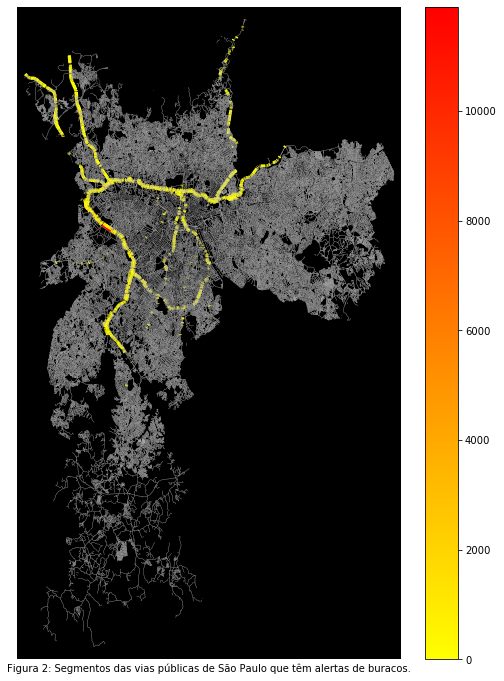

In [532]:
# fig.clear()
# ax.clear()
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=12, edge_color=edges_color,edge_linewidth=edges_width,
                       show=False, axis_off=False)
ax.set_facecolor('k')
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
cb = fig.colorbar(scalarMap)
ax.set_xlabel(f"Figura 2: Segmentos das vias públicas de {city} que têm alertas de buracos.");
fig

# Estatísticas Descritivas

In [533]:
stats = phc.generate_basic_stats(city, G)#, cost_per_meter, lane_size, avg_lane)

A tabela a seguir resume algumas estatísticas sobre as vias da cidade, indicando quantos segmentos possuem buracos e estimando sua representação no total.

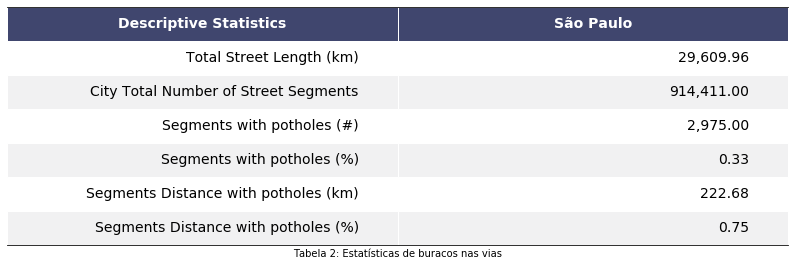

In [534]:
stats_table = stats.copy()
stats_table[city] = stats[city].apply(lambda x: f"{x:,.2f}")
stats_table.index.names = ["Descriptive Statistics"]
fig, ax, table = phc.render_mpl_table(stats_table.reset_index(), 'stats_table.png', city, col_width=7)
ax.set_xlabel(f"Tabela 2: Estatísticas de buracos nas vias");

# Custo Estimado

A fórmula de cálculo do custo é direta, $Custo = Comprimento * LarguraDaVia * Custo/m^2$, na qual largura da via e comprimento são dados em metros. Aqui, assumimos que os buracos não possuem largura maior que as faixas da via, logo, apenas uma das faixas deveriam ser contabilizadas no custo total estimado de reparo.

A tabela a seguir indica os valores dos parâmetros assumidos nesse relatório e o custo estimado de reparo de todos os segmentos de ruas com buracos reportados no período abordado.

In [535]:
cost_table = phc.generate_cost_estimates(city, G, cost_per_meter, lane_size)
cost_table[city] = cost_table[city].apply(lambda x: f"{x:,.2f}")
cost_table.index.names = ['Estimated Cost Parameters and Value']

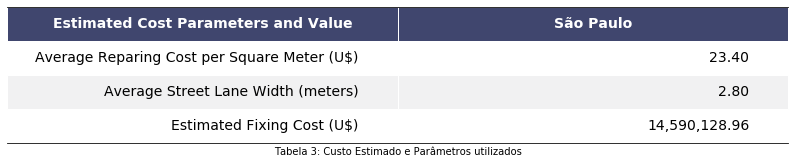

In [536]:
fig, ax, table = phc.render_mpl_table(cost_table.reset_index(), 'cost_table.png', city, col_width=7)
ax.set_xlabel(f"Tabela 3: Custo Estimado e Parâmetros utilizados");

In [ ]:
# ax1 = edges['cost'].hist(figsize=[15,10])
# ax1.grid(axis='x')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.set_ylabel("Número de Segmentos de Rua")
# ax1.set_xlabel("Quantidade de Intereções nos Alertas dos Segmentos")
# ax1.set_title("Distribuição de Segmentos por Quantidade de Interações");

# Interações com Alertas de Buracos

## Segmentos e Interações

O histograma a seguir indica a distribuição dos segmentos de rua de acordo com a quantidade de interações que cada segmento obteve, não contabilizando aqueles com nenhuma interação.

Ou seja, as colunas mais à direita no gráfico a seguir indicam os segmentos de vias com mais reclamações/iterações, representando aqueles que mais afetam os usuário.

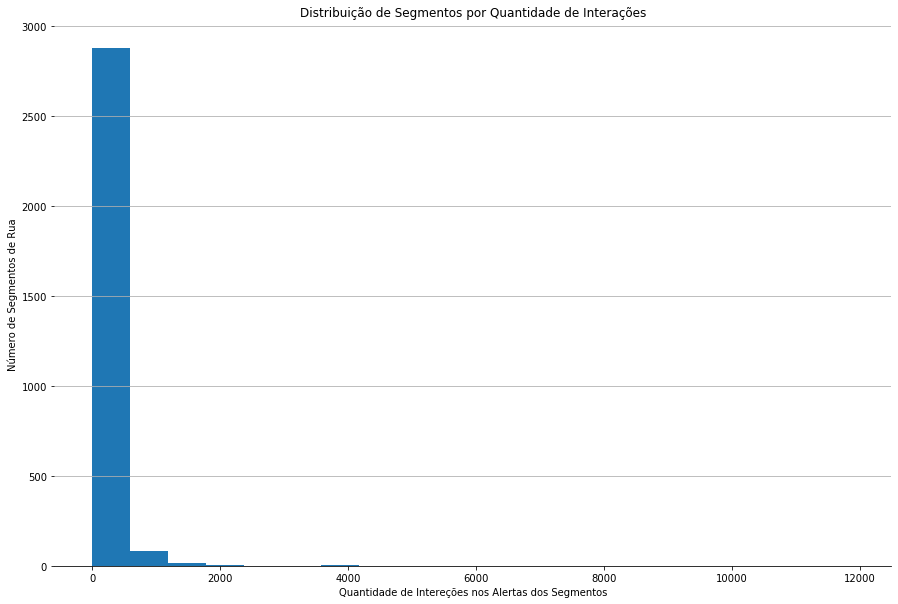

In [537]:
ax1 = edges[edges['interactions']>0]['interactions'].hist(figsize=[15,10], bins=20)
ax1.grid(axis='x')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel("Número de Segmentos de Rua")
ax1.set_xlabel("Quantidade de Intereções nos Alertas dos Segmentos")
ax1.set_title("Distribuição de Segmentos por Quantidade de Interações");

## Princípio de Pareto

In [538]:
edges = phc.estimate_cost(edges, cost_per_meter, lane_size)

In [539]:
edges = phc.calculate_pareto(edges)

Da última figura, nota-se que poucos segmentos são responsáveis por muitas interações, enquanto há vários segmentos com poucas interações dos usuários, isto é, há buracos que provocam maior impacto no trânsito e no bem-estar dos cidadãos.

Explorando mais a fundo essa relação de interações por segmento, queremos saber o quão próximo esse padrão está do Princípio de Pareto, ou seja, se 20% dos segmentos são responsáveis por 80% das interações em contraste a uma distribuição uniforme. A imagem abaixo contrasta a distribuição real e a uniforme.

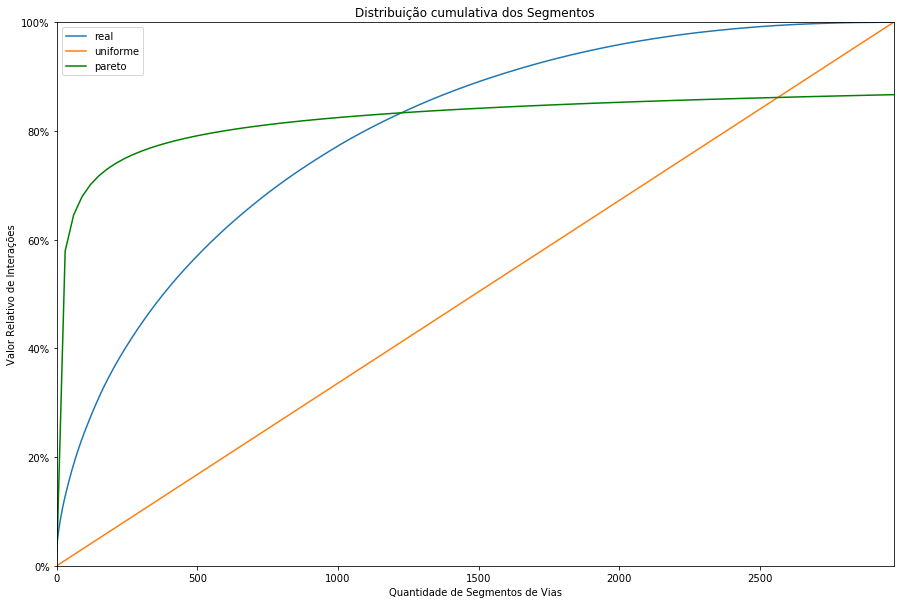

In [540]:
# calculating Pareto parameters
x_max = edges[['pareto']].dropna().shape[0]
b= -(np.log(0.2)/np.log(0.2*edges[['pareto']].dropna().shape[0]))
loc= -1
x = np.linspace(pareto.ppf(0.01, b, loc=loc), x_max, 100)

# plotting graphs
plot = edges[['pareto']].sort_values(by='pareto').rename(columns={"pareto":"real"}).dropna().reset_index().plot(y='real', figsize=(15,10))
fig = plot.get_figure()
plot.plot([0, x_max], [0,100], label='uniforme')
plot.plot(x, pareto.cdf(x, b, loc=loc)*100, 'g-', label='pareto')
plot.legend()
plot.set_ylim(0,100)
plot.set_xlim(0,x_max)
plot.set_yticklabels(['0%', '20%', '40%', '60%', '80%','100%'])
plot.set_title("Distribuição cumulativa dos Segmentos")
plot.set_ylabel("Valor Relativo de Interações")
plot.set_xlabel("Quantidade de Segmentos de Vias")
fig.savefig(OUTPUT_PATH / "cumulative_distribution.png")

In [541]:
pareto = phc.summary_pareto(city, edges)

Visando a otimização dos recursos públicos e as restrições orçamentárias, podemos formular uma estratégia de reparo das vias que priorize os buracos que provocam maior transtorno aos motoristas, o qual podemos inferir através dos números de interações com alertas de buracos dos usuários do Waze que transitam pela cidade.

Ordenando os segmentos de vias pelo seu número de interações de modo descendente e calculando seu custo de reparo, podemos identificar qual a porcentagem das reclamações poderiam ser atendidas para diferentes orçamentos. A tabela abaixo expõe essa informação.

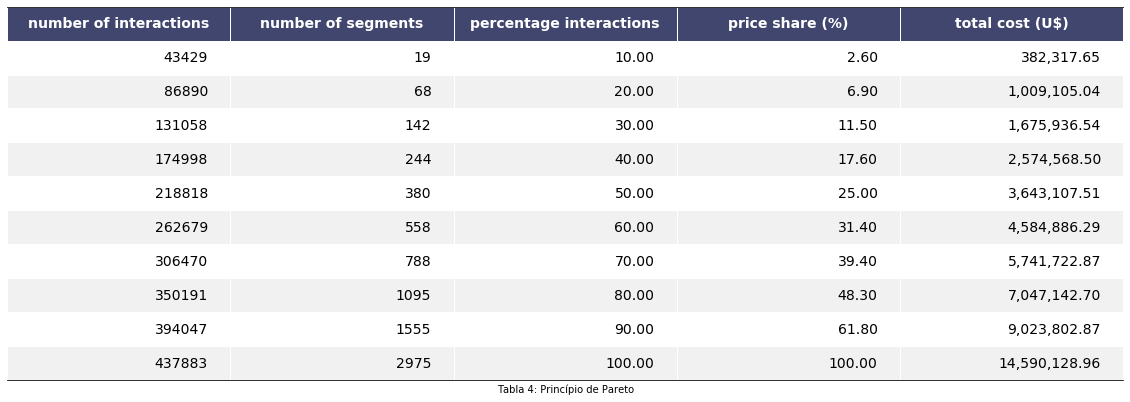

In [542]:
pareto_table = pareto.copy()
for col in pareto.columns:
    if col not in ['number of segments', 'number of interactions']:
        pareto_table[col] = pareto[col].apply(lambda x: f"{x:,.2f}")
fig, ax, table = phc.render_mpl_table(pareto_table[2::2], 'pareto_table.png', city)
ax.set_xlabel(f"Tabla 4: Princípio de Pareto");

A imagem abaixo mostra a relação entre o percentual do custo total versus o percentual de reclamações. Observa-se que aplicando adequadamente os recursos é possível atender grande volume das reclamações.

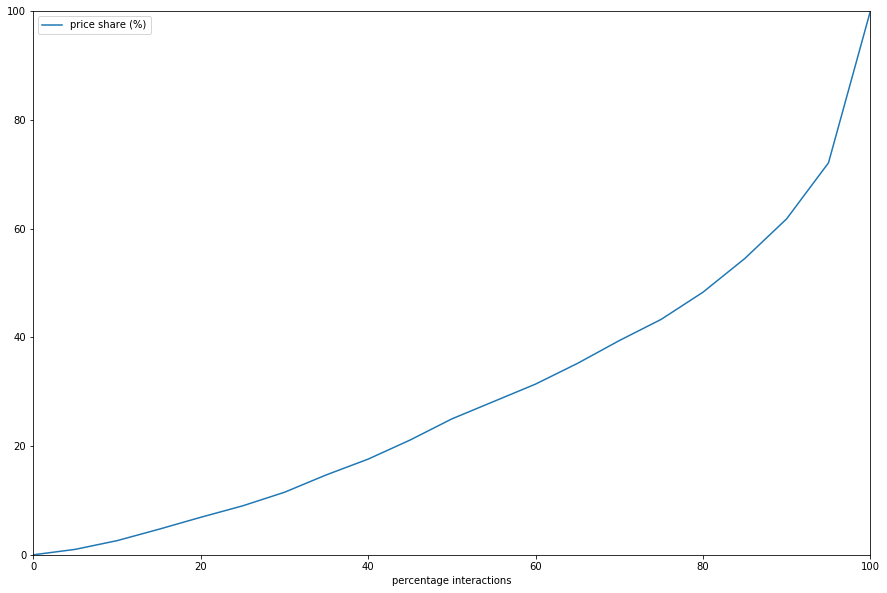

In [543]:
plot = pareto.plot(x='percentage interactions', y='price share (%)', figsize=(15,10))
fig = plot.get_figure()
plot.set_ylim(0,100)
plot.set_xlim(0,100)
fig.savefig(OUTPUT_PATH / "priceshare x percentage_interactions.png")

## Mapas das vias com mais reclamações.

As imagens a seguir indicam as posições dos buracos que mais concentram as interações dos usuários.

In [544]:
Gcopy = G_proj.copy()
nx.set_edge_attributes(Gcopy, 0, 'alerts_count')
nx.set_edge_attributes(Gcopy, 0, 'interactions')
edges_pareto = edges[edges['alerts_count']>0].loc[:,['u','v', 'key', 'alerts_count', 'interactions', 'cost', 'pareto']].rename(columns={'key':'k'})

In [545]:
top = 10
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localização dos Buracos que concentram <b>{top}%</b> das reclamações."""))
    print(f"Custo de reparo estimado em U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

Localização dos Buracos que concentram <b>10%</b> das reclamações.

Custo de reparo estimado em U$382,317.65


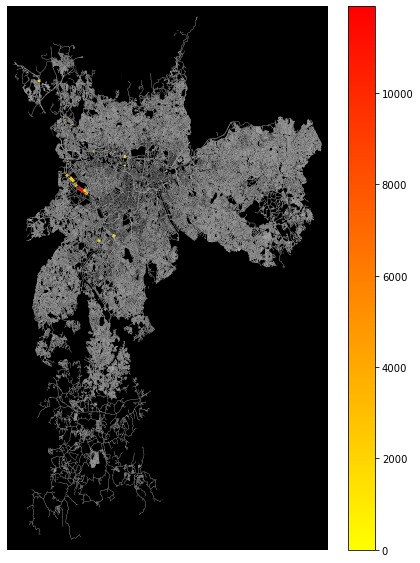

In [546]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

In [547]:
top = 25
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localização dos Buracos que concentram <b>{top}%</b> das reclamações."""))
    print(f"Custo de reparo estimado em U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

Localização dos Buracos que concentram <b>25%</b> das reclamações.

Custo de reparo estimado em U$1,319,420.79


In [ ]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

In [ ]:
top = 50
if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Localização dos Buracos que concentram <b>{top}%</b> das reclamações."""))
    print(f"Custo de reparo estimado em U${pareto.loc[pareto['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")
    edges_with_potholes_pareto = edges_pareto[edges_pareto['pareto'] < top].groupby(['u','v','k']).sum().to_dict('index')
    nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

In [ ]:
phc.plot_graph_potholes(Gcopy) if edges_pareto[edges_pareto['pareto'] < top].shape[0] > 0 else None

# Anexos

In [ ]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', 'pareto']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

In [ ]:
top = 10
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

\newpage

In [ ]:
top = 25
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

\newpage

In [ ]:
top = 50
if edges_table[edges_table['pareto'] < top].shape[0] > 0:
    display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações."""))
    with pd.option_context('display.max_rows', None):
        print(edges_table.loc[edges_table['pareto'] < top, ['street', 'interactions', 'cost']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index())

# Export to Kepler <a class='tocSkip'>

In [ ]:
kepler_data = phc.export_kepler(city, edges)